In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.diagnostic import predict, top_k_accuracy, per_class_accuracy,\
    entropy, model_calibration, most_confused_classes, most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Load the model

In [4]:
from get_squeezenet import get_model

In [5]:
model, _, _ = get_model()
model.load_state_dict(torch.load('model.pytorch_state'))

# Error analysis

### get all predictions

In [6]:
_, val_folder = get_image_folders()

val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=256, shuffle=False
)

In [7]:
val_predictions, val_true_targets = predict(model, val_iterator_no_shuffle)

100%|██████████| 40/40 [00:13<00:00,  3.26it/s]


### get human readable class names

In [8]:
data_dir = '/home/ubuntu/data/tiny-imagenet-200/'

class_names = pd.read_csv(data_dir + 'words.txt', sep='\t', header=None)
class_names.columns = ['code', 'description']

decode = {}
for i, row in class_names.iterrows():
    decode[row.code] = row.description
    

# class index to human readable format
decode = {
    val_folder.class_to_idx[code]: decode[code] 
    for code in val_folder.class_to_idx
}

### number of misclassified images (there are overall 10k images in the val dataset)

In [9]:
hits = val_predictions.argmax(1) == val_true_targets
n_errors = (~hits).sum()
n_errors

4755

### logloss and accuracies

In [10]:
log_loss(val_true_targets, val_predictions)

1.968486776923378

In [11]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.52449999999999997

In [12]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.64329999999999998, 0.70879999999999999, 0.74480000000000002, 0.77380000000000004, 0.85340000000000005]


### entropy of predictions

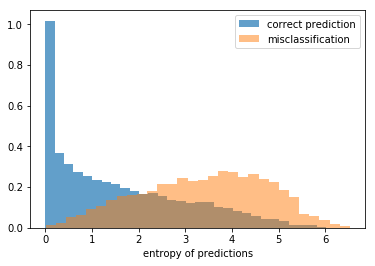

In [13]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

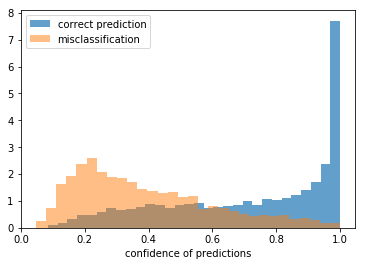

In [14]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

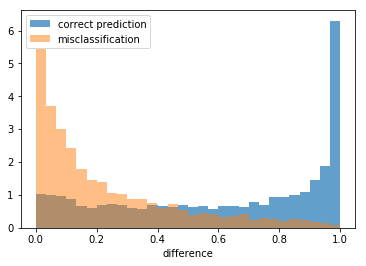

In [15]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

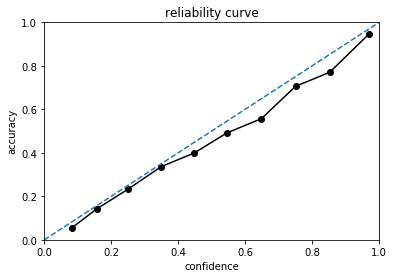

In [16]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

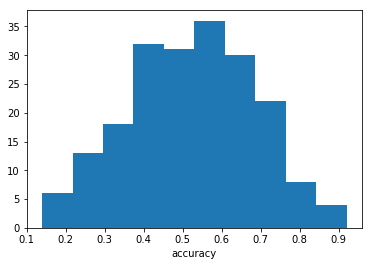

In [17]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [18]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

syringe 0.14
Labrador retriever 0.16
plunger, plumber's helper 0.18
water jug 0.18
bow tie, bow-tie, bowtie 0.2
wooden spoon 0.2
drumstick 0.22
dumbbell 0.22
nail 0.22
pop bottle, soda bottle 0.22
reel 0.22
bucket, pail 0.24
hog, pig, grunter, squealer, Sus scrofa 0.24
umbrella 0.24
barbershop 0.26


### most confused pairs of classes

In [19]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=12
)
confused_pairs

[('tabby, tabby cat', 'Egyptian cat'),
 ('walking stick, walkingstick, stick insect', 'mantis, mantid'),
 ('apron', 'poncho'),
 ('basketball', 'volleyball'),
 ('beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
  'convertible'),
 ('beer bottle', 'pop bottle, soda bottle'),
 ('convertible', 'sports car, sport car'),
 ('frying pan, frypan, skillet', 'wok'),
 ('magnetic compass', 'stopwatch, stop watch'),
 ('plate', 'ice cream, icecream'),
 ('mashed potato', 'meat loaf, meatloaf'),
 ('orange', 'lemon'),
 ('lakeside, lakeshore', 'seashore, coast, seacoast, sea-coast')]